Task - 05 Develop a model that can accurately recognize food items from images and estimate their calorie content, enabling users to track their dietary intake and make informed food choices.

Dataset Used :  https://www.kaggle.com/dansbecker/food-101

Introduction
In this project, we explore the task of food classification using Convolutional Neural Networks (CNNs). The dataset used is Food-101, consisting of images from various food categories. So, we will make classisication for 10 random categories of food.

![foods](https://engineeringhulk.com/wp-content/uploads/2023/05/Classification-of-food-1.jpg)

Let's get started!

# Getting the Environment Ready

In [2]:
import pyforest
import random
import zipfile
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import load_model
import matplotlib.image as mpim
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import keras_tuner as kt

## Data Exploration
​
### Selected Classes
We randomly selected 10 classes from the Food-101 dataset for our classification task. These classes are:

In [3]:
# Access the directory
data_dir = 'L:/Food/food-101/food-101/images'
class_names_file_path = 'L:/Food/food-101/food-101/meta/classes.txt'

# Read class names from the file into a list
with open(class_names_file_path, 'r') as file:
    all_class_names = [line.strip() for line in file]

# Choose 10 classes randomly
chosen_classes = random.sample(all_class_names, 10)
print(chosen_classes)

# List of real class names
classes = chosen_classes

# Set the number of classes
num_classes = len(classes)

['chicken_quesadilla', 'beef_tartare', 'escargots', 'chicken_curry', 'pork_chop', 'beet_salad', 'macarons', 'club_sandwich', 'peking_duck', 'tacos']


### Data Visualization
We display a random image from each selected class to get an overview of the dataset.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

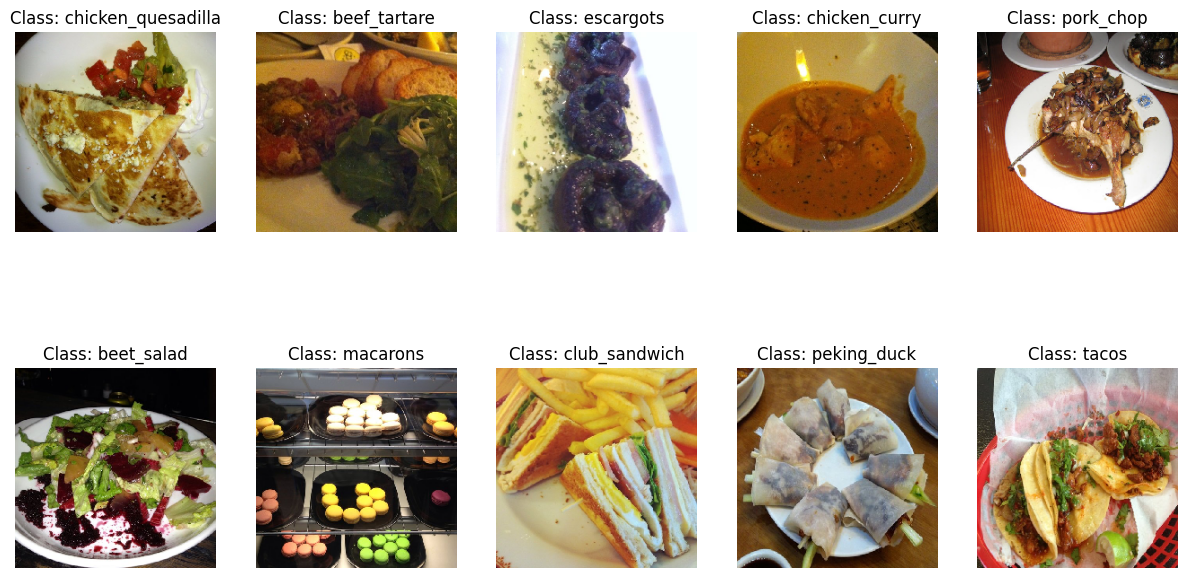

In [4]:
# Display a random image from each class folder
plt.figure(figsize=(15, 8))
for i in range(num_classes):
    class_folder = classes[i]
    class_path = os.path.join(data_dir, class_folder)
    
    # Get a random image from the class folder
    random_image = random.choice(os.listdir(class_path))
    image_path = os.path.join(class_path, random_image)
    
    # Load and display the image
    img = load_img(image_path, target_size=(224, 224))
    plt.subplot(2, 5, i + 1)
    plt.imshow(img)
    plt.title(f"Class: {class_folder}")
    plt.axis('off')

plt.show()

## Baseline CNN Model
We started with a simple Convolutional Neural Network model with the following architecture:
- Conv2D layers with ReLU activation
- MaxPooling2D layers
- Flatten layer
- Dense layers with ReLU activation and Dropout
- Output layer with softmax activation

In [5]:
# Create a sequential model
model = models.Sequential()

# Add convolutional layers with activation and pooling
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Flatten the output and add dense layers
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

### Model Training
The baseline model was trained on the dataset with data augmentation using ImageDataGenerator. Early stopping was employed to prevent overfitting.

In [6]:
# Data Augmentation using ImageDataGenerator
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # Split the data into training and validation
)

batch_size = 32

# Use the same generator for both training and validation
generator = datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',  # For training data
    classes=classes
)

validation_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',  # For validation data
    classes=classes
)

# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    generator,
    epochs=20,
    validation_data=validation_generator,
    callbacks=[early_stopping]
)

Found 8000 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
Epoch 1/20


250/250 [==============================] - 297s 1s/step - loss: 2.3234 - accuracy: 0.1331 - val_loss: 2.2638 - val_accuracy: 0.1550
Epoch 2/20
250/250 [==============================] - 219s 875ms/step - loss: 2.2171 - accuracy: 0.1873 - val_loss: 2.1492 - val_accuracy: 0.2440
Epoch 3/20
250/250 [==============================] - 204s 816ms/step - loss: 2.1211 - accuracy: 0.2375 - val_loss: 2.0756 - val_accuracy: 0.2785
Epoch 4/20
250/250 [==============================] - 228s 912ms/step - loss: 2.0406 - accuracy: 0.2714 - val_loss: 1.9496 - val_accuracy: 0.3125
Epoch 5/20
250/250 [==============================] - 213s 851ms/step - loss: 1.9695 - accuracy: 0.2932 - val_loss: 1.9017 - val_accuracy: 0.3525
Epoch 6/20
250/250 [==============================] - 211s 845ms/step - loss: 1.9132 - accuracy: 0.3215 - val_loss: 1.8832 - val_accuracy: 0.3240
Epoch 7/20
250/250 [===================

### Model Evaluation
We evaluate the baseline model on the validation set and visualize the performance metrics.

In [7]:
# Evaluate the model on the validation set
evaluation = model.evaluate(validation_generator)
print("Loss:", evaluation[0])
print("Accuracy:", evaluation[1])

63/63 [==============================] - 31s 492ms/step - loss: 1.4167 - accuracy: 0.5250
Loss: 1.416732907295227
Accuracy: 0.5249999761581421


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

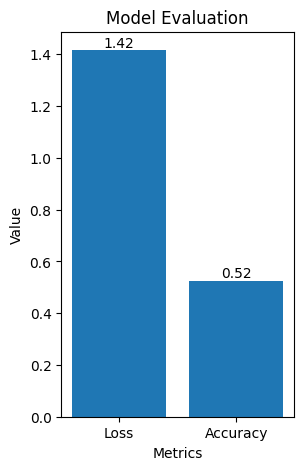

In [8]:
# Visualize the evaluation metrics with data labels
plt.figure(figsize=(3, 5))
bars = plt.bar(['Loss', 'Accuracy'], [evaluation[0], evaluation[1]])

# Add data labels to the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

plt.title('Model Evaluation')
plt.xlabel('Metrics')
plt.ylabel('Value')
plt.show()

### Training History Visualization
We visualize the training and validation loss, as well as accuracy, over epochs.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

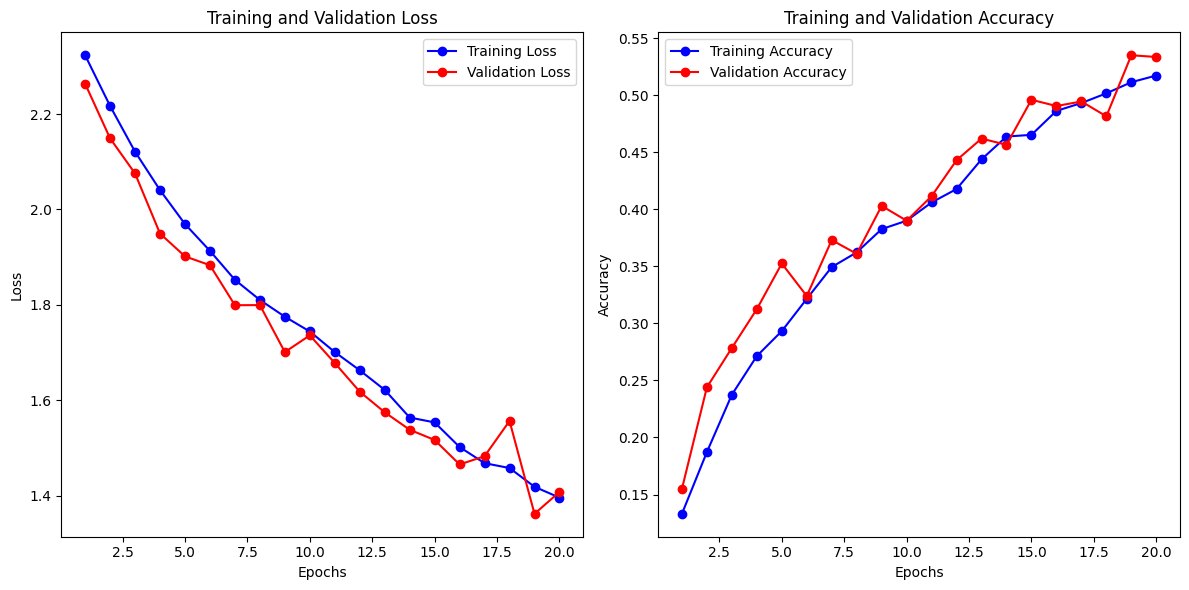

In [9]:
# Visualize the training history (loss and accuracy over epochs)
history_dict = history.history

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']

epochs = range(1, len(loss_values) + 1)

plt.figure(figsize=(12, 6))

# Plotting Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, loss_values, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss_values, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, acc_values, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc_values, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## Hyperparameter Tuning with Keras Tuner
To improve the model performance, we employed Keras Tuner to search for optimal hyperparameters.

In [10]:
# Instantiate the VGG16 base model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

# Define a model-building function
def build_model(hp):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False

    model = models.Sequential([
        base_model,
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(hp.Float('dropout', 0, 0.5, step=0.1, default=0.5)),
        layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Instantiate the tuner
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=10,
    factor=3,
    directory='tuner_dir',
    project_name='food_classification'
)

# Search for the best hyperparameters
tuner.search(
    generator,
    epochs=20,
    validation_data=validation_generator,
    callbacks=[early_stopping],
)

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

Trial 5 Complete [00h 32m 13s]
val_accuracy: 0.5630000233650208

Best val_accuracy So Far: 0.5895000100135803
Total elapsed time: 02h 58m 28s


### Search for Hyperparameters
We used Keras Tuner's Hyperband algorithm to search for the best hyperparameters.

In [11]:
# Print the best hyperparameters
print(f"Best Hyperparameters:\n{best_hps.values}")

Best Hyperparameters:
{'dropout': 0.1, 'tuner/epochs': 2, 'tuner/initial_epoch': 0, 'tuner/bracket': 2, 'tuner/round': 0}


In [12]:
# Build the model with the best hyperparameters
best_model = tuner.hypermodel.build(best_hps)

# Train the best model with the best hyperparameters
history_best_model = best_model.fit(
    generator,
    epochs=20,
    validation_data=validation_generator,
    callbacks=[early_stopping]
)

# Save the best model and its weights
best_model.save('best_model.h5')

Epoch 1/20
250/250 [==============================] - 1003s 4s/step - loss: 1.9264 - accuracy: 0.3946 - val_loss: 1.3857 - val_accuracy: 0.5360
Epoch 2/20
250/250 [==============================] - 983s 4s/step - loss: 1.4132 - accuracy: 0.5132 - val_loss: 1.2694 - val_accuracy: 0.5645
Epoch 3/20
250/250 [==============================] - 978s 4s/step - loss: 1.3094 - accuracy: 0.5514 - val_loss: 1.2758 - val_accuracy: 0.5750
Epoch 4/20
250/250 [==============================] - 980s 4s/step - loss: 1.2457 - accuracy: 0.5774 - val_loss: 1.1944 - val_accuracy: 0.5935
Epoch 5/20
250/250 [==============================] - 1007s 4s/step - loss: 1.1983 - accuracy: 0.5926 - val_loss: 1.1842 - val_accuracy: 0.6020
Epoch 6/20
250/250 [==============================] - 998s 4s/step - loss: 1.1933 - accuracy: 0.5931 - val_loss: 1.1519 - val_accuracy: 0.6180
Epoch 7/20
250/250 [==============================] - 998s 4s/step - loss: 1.1729 - accuracy: 0.5939 - val_loss: 1.1980 - val_accuracy: 0.60

l:\Prodigy Internship\.venv\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [13]:
# Evaluate the best model on the validation set
evaluation = best_model.evaluate(validation_generator)
print("Best Model Validation Loss:", evaluation[0])
print("Best Model Validation Accuracy:", evaluation[1])

63/63 [==============================] - 189s 3s/step - loss: 1.1189 - accuracy: 0.6320
Best Model Validation Loss: 1.1188931465148926
Best Model Validation Accuracy: 0.6320000290870667


In [14]:
# Predictions on the validation set using the best model
y_true = validation_generator.classes
y_pred_probs = best_model.predict(validation_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

# Calculate accuracy on the validation set
validation_accuracy = accuracy_score(y_true, y_pred)
print("Validation Accuracy with Best Model:", validation_accuracy)

63/63 [==============================] - 196s 3s/step


<IPython.core.display.Javascript object>

Validation Accuracy with Best Model: 0.106


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

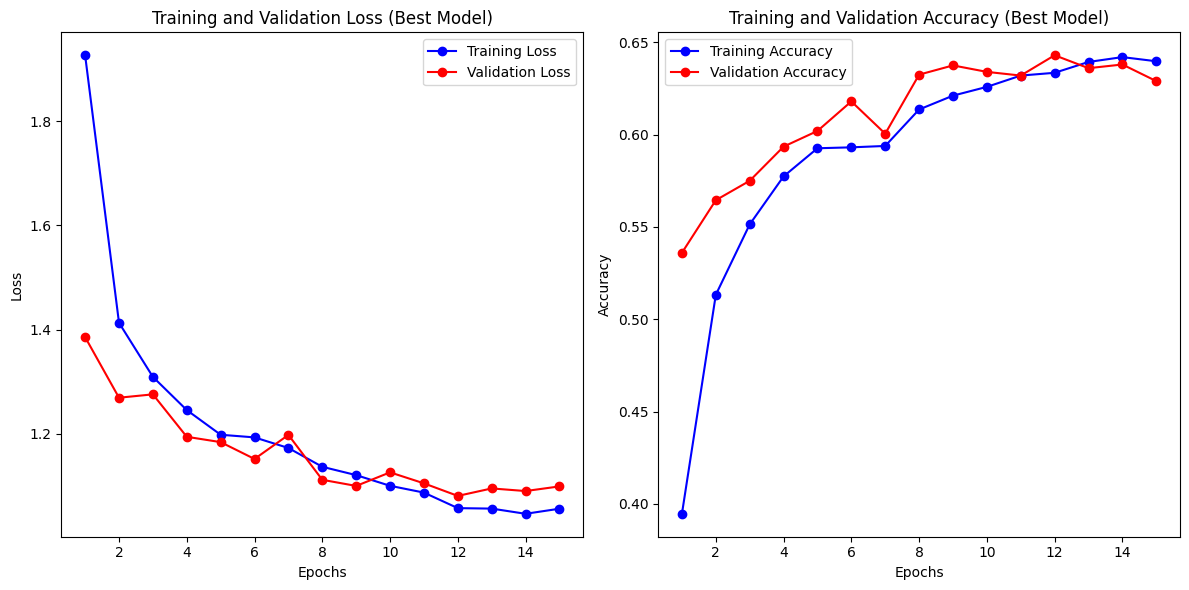

In [15]:
# Visualize the training history for the best model
history_dict_best_model = history_best_model.history

loss_values_best_model = history_dict_best_model['loss']
val_loss_values_best_model = history_dict_best_model['val_loss']
acc_values_best_model = history_dict_best_model['accuracy']
val_acc_values_best_model = history_dict_best_model['val_accuracy']

epochs_best_model = range(1, len(loss_values_best_model) + 1)

plt.figure(figsize=(12, 6))

# Plotting Loss
plt.subplot(1, 2, 1)
plt.plot(epochs_best_model, loss_values_best_model, 'bo-', label='Training Loss')
plt.plot(epochs_best_model, val_loss_values_best_model, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss (Best Model)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_best_model, acc_values_best_model, 'bo-', label='Training Accuracy')
plt.plot(epochs_best_model, val_acc_values_best_model, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy (Best Model)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [16]:
# Load the saved model
loaded_model = load_model('best_model.h5')

def predict_and_display(image_path):
    # Load and preprocess the image
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0

    # Make predictions
    predictions = loaded_model.predict(img_array)
    predicted_class = np.argmax(predictions)

    # Display the image with the predicted label
    plt.imshow(img)
    plt.title(f"Predicted Class: {classes[predicted_class]}")
    plt.axis('off')
    plt.show()

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 422ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

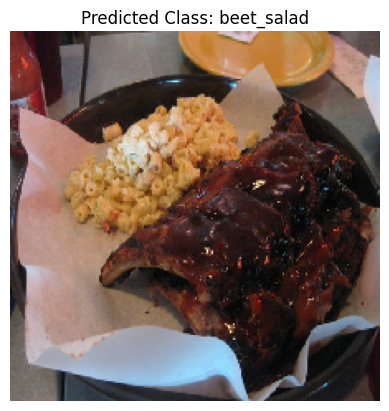

In [17]:
# Example usage
image_path = 'L:/Food/food-101/food-101/images/baby_back_ribs/5712.jpg'
predict_and_display(image_path)

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 174ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

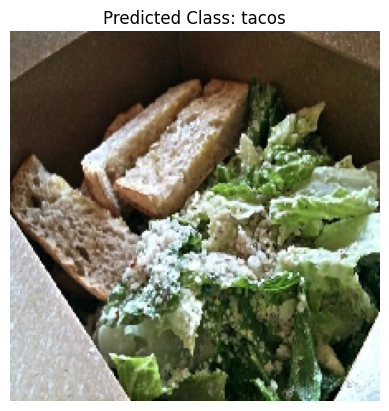

In [18]:
# Example usage
image_path = 'L:/Food/food-101/food-101/images/caesar_salad/62832.jpg'
predict_and_display(image_path)

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 174ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

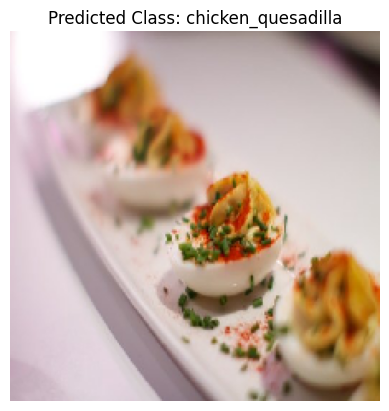

In [19]:
# Example usage
image_path = 'L:/Food/food-101/food-101/images/deviled_eggs/58654.jpg'
predict_and_display(image_path)

# conclusion

This project successfully tackled the task of food classification using CNNs. The journey began with the exploration of the Food-101 dataset, where we randomly selected 10 classes for classification. A baseline CNN model was designed and trained, demonstrating good performance on the validation set.
